<h2><center>Title: <span style="color:blue">Logistic Regression as a Neural Network</span></center></h2>

<center><h3><u>Dataset:</u> Fruit Dataset</h3>
<h3><u>Goal:</u> Classify a given image as an <span style="color:red">Orange</span> or <span style="color:red">Non_Orange</span></h3></center>

In [ ]:
#install Opencv to read images
pip install opencv-python

In [3]:
#importing some important libraries
from random import shuffle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

### Code to convert folder of images to h5 file

In [6]:

def CreateH5file(h5Path,Filepath):
    shuffle_data = True  # shuffle the addresses
    
    hdf5_path = h5Path  # file path for the created .hdf5 file
    file_path = Filepath # the original data path
    
    # get all the image paths
    addrs = glob.glob(file_path)
    
    # label the data as 0=Non_Orange, 1=Orange
    labels = [1 if 'Orange' in addrs else 0 for addrs in addrs] 
    
    # shuffle data
    if shuffle_data:
        c = list(zip(addrs, labels)) # use zip() to bind the images and labels together
        shuffle(c)
 
        (addrs, labels) = zip(*c)  # *c is used to separate all the tuples in the list c,  
                               # "addrs" then contains all the shuffled paths and 
                               # "labels" contains all the shuffled labels.
                               
    addrs_data = addrs[0:int(len(addrs))]
    labels_data = labels[0:int(len(labels))]
    
    ##################### second part: create the h5py object #####################
   
    data_shape = (len(addrs_data), 128, 128, 3)

    # open a hdf5 file and create earrays 
    f = h5py.File(hdf5_path, mode='w')

    f.create_dataset("data_img", data_shape, np.uint8)
    
    # the ".create_dataset" object is like a dictionary, the "train_labels" is the key. 
    f.create_dataset("data_labels", (len(addrs_data),), np.uint8)
    f["data_labels"][...] = labels_data

    
    if 'Test' in h5Path:
        classes=['non_orange','orange']
        f["classes"]=classes
    
    ######################## third part: write the images #########################

    # loop over paths
    for i in range(len(addrs_data)):
  
        if i % 1000 == 0 and i > 1:
            print ('data: {}/{}'.format(i, len(addrs_data)) )

        addr = addrs_data[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)# resize to (128,128)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
        f["data_img"][i, ...] = img[None] 

    f.close()

### Creating h5 files using above function

In [7]:
#Creating H5 file for training data
CreateH5file('Dataset/Fruits_Train.h5','Dataset/Training/*.jpg')

#Creating H5 file for test data
CreateH5file('Dataset/Fruits_Test.h5','Dataset/Test/*.jpg')

### Load_Dataset function to load data from h5 file

In [8]:
      
def load_dataset():
    train_dataset = h5py.File('Dataset/Fruits_Train.h5', "r")
    train_set_x_orig = np.array(train_dataset["data_img"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["data_labels"][:]) # your train set labels

    test_dataset = h5py.File('Dataset/Fruits_Test.h5', "r")
    test_set_x_orig = np.array(test_dataset["data_img"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["data_labels"][:]) # your test set labels

    classes = np.array(test_dataset["classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

### Loading the data using load_dataset()

In [9]:
# Loading the data (orange/non-orange)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non_orange' picture.


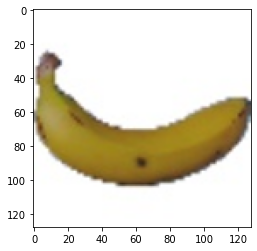

In [10]:
# Example of a picture
index = 30
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

<center><h2>Dataset Preprocessing</h2></center>

### Checking the shape and size of training and test dataset

In [11]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 100
Number of testing examples: m_test = 30
Height/Width of each image: num_px = 128
Each image is of size: (128, 128, 3)
train_set_x shape: (100, 128, 128, 3)
train_set_y shape: (1, 100)
test_set_x shape: (30, 128, 128, 3)
test_set_y shape: (1, 30)


<h3>1) Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px*num_px*3, 1).</h3>

In [12]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (49152, 100)
train_set_y shape: (1, 100)
test_set_x_flatten shape: (49152, 30)
test_set_y shape: (1, 30)
sanity check after reshaping: [255 255 255 255 255]


### 2) Standardize the dataset.

In [13]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<center><h2>Building parts of Logistic Regression algorithm</h2></center>

### 1) Sigmoid Function:

In [14]:
##1- Sigmoid function

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 /(1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

#### Example:

In [15]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 2) Initialize Parameters

In [16]:

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

#### Example:

In [17]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 3) Forward and Backward propagation

In [18]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-orange, 1 if orange) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (-1./m)*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)), axis=1) # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

#### Example:


In [19]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = [0.00145558]
cost = 5.801545319394553


### 4) Optimization using gradient descent

In [73]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-orange, 1 if orange), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and grad ient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w=w, b=b, X=X, Y=Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

#### Example:

In [21]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = [1.92535983]
dw = [[0.67752042]
 [1.41625495]]
db = [0.2191945]


### 5) Predict Function

In [35]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of an orange being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1            
        else:
            Y_prediction[0, i] = 0

    assert(Y_prediction.shape == (1, m))
    
    #print(Y_prediction.astype(int))
    return Y_prediction.astype(int)

#### Example:

In [27]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


<center><h2>Merge all functions into a model</h2></center>

In [33]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

###  Passing dataset to train the model

In [32]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.010120
Cost after iteration 200: 0.005213
Cost after iteration 300: 0.003836
Cost after iteration 400: 0.003136
Cost after iteration 500: 0.002705
Cost after iteration 600: 0.002410
Cost after iteration 700: 0.002191
Cost after iteration 800: 0.002021
Cost after iteration 900: 0.001883
Cost after iteration 1000: 0.001768
Cost after iteration 1100: 0.001670
Cost after iteration 1200: 0.001585
Cost after iteration 1300: 0.001511
Cost after iteration 1400: 0.001444
Cost after iteration 1500: 0.001384
Cost after iteration 1600: 0.001330
Cost after iteration 1700: 0.001281
Cost after iteration 1800: 0.001235
Cost after iteration 1900: 0.001193
train accuracy: 100.0 %
test accuracy: 100.0 %


### Example:

y = 0, you predicted that it is a "non_orange" picture.


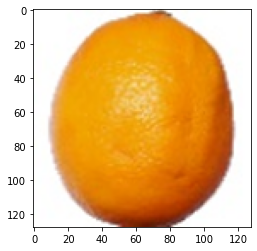

In [83]:
# Example of a picture that was wrongly classified.
index = 12
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")

### Plotting the cost function and the gradients

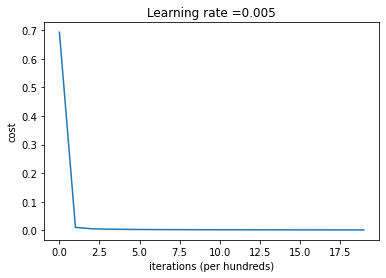

In [40]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### Test with your own image 

C:\Users\NIDAKH~1\AppData\Local\Temp/ipykernel_2600/2649589062.py:15: RuntimeWarning: overflow encountered in exp
  s = 1 /(1 + np.exp(-z))


y = 0, your algorithm predicts a "non_orange" picture.


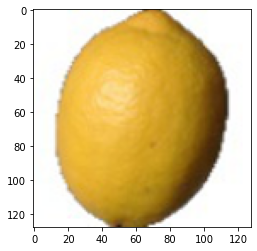

In [88]:

my_image = "7_100.jpg"   # change this to the name of your image file 

# We preprocess the image to fit your algorithm.
fname = "Test_Images/" + my_image

my_image = np.array(plt.imread(fname))
img = Image.fromarray(my_image)
img = img.resize((num_px,num_px))
image = np.asarray(img)
image = image.reshape(1,num_px*num_px*3)
image = image.T
my_predicted_image = predict(d["w"], d["b"], image)

plt.imshow(img)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")